In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
#import time

In [2]:
class Bandit(object):
    def __init__(self, probability):
        self.probability = probability

    def pull(self):
        reward = np.random.binomial(1, self.probability)
        return reward

In [3]:
class BanditStrat(object):
    def __init__(self, noBandits, banditProbs, noRounds):
        #bandits initialization
        self.banditProbs = banditProbs
        self.noRounds = noRounds
        self.noBandits = noBandits
        self.bandits = []
        for i in range(self.noBandits):
            self.bandits.append(Bandit(self.banditProbs[i]))
        self.winCounts = np.zeros((self.noBandits))
        self.loseCounts = np.zeros((self.noBandits))
        self.winRateRecord = np.zeros((self.noRounds, self.noBandits))
        self.regret = np.zeros(self.noRounds)
        self.rewards = 0
        self.cumRegret = 0.0

    def plot(self):
        p = np.linspace(0, 1, 100)
        graphs = []
        y = np.linspace(0, 20, 10)
        ymax = 10
        plt.ion()
        if isinstance(self, Thompson):
            for bandit in range(self.noBandits):
                graphs.append(plt.plot(p, self.pbetas[0][bandit], label = ' p = ' + str(self.banditProbs[bandit]))[0])
                plt.legend(loc=0)
                plt.ylim(0, ymax)
                plt.xlim(-0.1, 1.1)
            for roundNo in range(1, self.noRounds):
                for bandit in range(self.noBandits):
                    y = self.pbetas[roundNo][bandit]
                    graphs[bandit].set_ydata(y)
                    if np.max(y) + 5> ymax:
                        ymax += 10
                    plt.ylim(0, ymax)
                    plt.draw()

                    plt.pause(0.000001)
        #not thompson sampling
        else:
            for bandit in range(self.noBandits):
                inferredHitRate = np.round(self.winRateRecord[0][bandit], 3)
                graphs.append(plt.plot(np.ones(10) * inferredHitRate, y, '--', label = ' p = ' + str(self.banditProbs[bandit]) + ', inferred p: ' + str(inferredHitRate))[0])
                plt.legend(loc=0)
                plt.ylim(0, ymax)
                plt.xlim(-0.1, 1.1)
            for roundNo in range(1, self.noRounds):
                    for bandit in range(self.noBandits):
                        inferredHitRate = np.round(self.winRateRecord[roundNo][bandit], 3)
                        graphs[bandit].set_xdata(np.ones(10) * inferredHitRate)
                        graphs[bandit].set_label(' p = ' + str(self.banditProbs[bandit]) + ', inferred p: ' + str(inferredHitRate))
                        if np.max(y) + 5> ymax:
                            ymax += 10
                        plt.ylim(0, ymax)
                        plt.legend(loc=0)
                        plt.draw()
                        plt.pause(0.000001)

    def plot_result(self):
        p = np.linspace(0, 1, 100)
        y = np.linspace(0, 20, 10)
        if isinstance(self, Thompson):
            for bandit in range(self.noBandits):
                plt.plot(p, self.pbetas[self.noRounds - 1][bandit], label = 'p = '+ str(self.banditProbs[bandit]))
        else:
            for bandit in range(self.noBandits):
                inferredHitRate = np.round(self.winRateRecord[-1][bandit], 3)
                plt.plot(np.ones(10) * inferredHitRate, y, '--', label = ' p = ' + str(self.banditProbs[bandit]) + ', inferred p: ' + str(inferredHitRate))
        plt.xlim(-0.1, 1.1)
        plt.title(type(self).__name__)
        plt.legend(loc='best')
        #plt.xlim(0, 0.25)
        #plt.show()

    def displayHitRates(self):
        print('\n' + type(self).__name__ + ' hit probabilities: ' + str(self.banditProbs))
        print('bandit trials:')
        print(self.winCounts + self.loseCounts)
        print('bandit wins:')
        print(self.winCounts)
        totalHits = np.sum(self.winCounts)
        print('inferred hit rates for bandits: ')
        print(str(self.winCounts/(self.loseCounts+self.winCounts)))
        print('Total trial: ' + str(self.noRounds))
        print('Total hits: ' + str(totalHits))
        print('Total hit rate: ' + str(totalHits/self.noRounds))

In [4]:
class EpsilonGreedy(BanditStrat):
    def __init__(self, noBandits, banditProbs, noRounds, epsilon):
        BanditStrat.__init__(self, noBandits, banditProbs, noRounds)
        self.epsilon = epsilon

    def run(self):

        for i in range(1, self.noRounds):
            #in each rounds, generate a random value and compare it with epsilon
            # 1. if the val > epsilon, exploit(run the highest value one)
            # 2. if val < epsilon, explore(select random bandit)  
            #DRAW MACHINE
            if np.random.sample() < self.epsilon:
                #print "smaller"
                #explore (including the highest value one)
                banditNo = np.random.randint(self.noBandits)
                #print banditNo
            else:
                #exploit
                #print "bigger, exploit"
                #print self.winRateRecord[i-1]
                banditNo = np.argmax(self.winRateRecord[i-1])
                #print banditNo

            #PULL ARM OF SELECTED MACHINE AND UPDATE
            reward = self.bandits[banditNo].pull()			
            if reward == 1:
                self.winCounts[banditNo] += 1
            else:
                self.loseCounts[banditNo] += 1
            self.rewards += reward
            self.winRateRecord[i] = self.winRateRecord[i-1]
            self.winRateRecord[i][banditNo] = float(self.winCounts[banditNo])/(self.winCounts[banditNo]+self.loseCounts[banditNo])
            self.regret[i] = np.max(self.banditProbs) - self.banditProbs[banditNo]
        self.cumRegret = np.cumsum(self.regret)

In [5]:
class Thompson(BanditStrat):
    #thompson sampling uses beta distribution probability
    def __init__(self, noBandits, banditProbs, noRounds):
        BanditStrat.__init__(self, noBandits, banditProbs, noRounds)#, pbetas
        self.p = np.linspace(0, 1, 100)
        #betas contains [winCount+1, loseCount+1]
        self.betas = np.ones((self.noBandits, 2))
        #probability distribution
        self.pbetas = np.zeros((self.noRounds, self.noBandits, 100))

    def run(self):
        for i in range(1, self.noRounds):

            # 1. DRAW MACHINES
            #for each machine, generate a random number with its beta distribution, and pull the lever of the bandit with highest value
            betaSamplingVals = np.zeros((self.noBandits, 1))
            for bandit in range(self.noBandits):
                betaSamplingVals[bandit] = np.random.beta(self.betas[bandit][0], self.betas[bandit][1])
            banditNo = np.argmax(betaSamplingVals)

            # PULL ARM OF SELECTED MACHINE AND UPDATE
            reward = self.bandits[banditNo].pull()
            if reward == 1:
                self.winCounts[banditNo] += 1
                self.betas[banditNo][0] += 1
            else:
                self.loseCounts[banditNo] += 1
                self.betas[banditNo][1] += 1
            self.winRateRecord[i] = self.winCounts/(self.winCounts + self.loseCounts)

            #calculate the new probability density function for the machines(only pulled machine needs update, other machines remain the same)			
            for bandit in range(self.noBandits):
                self.pbetas[i][bandit] = stats.beta.pdf(self.p, self.betas[bandit][0], self.betas[bandit][1])
            self.rewards += reward
            self.regret[i] = np.max(self.banditProbs) - self.banditProbs[banditNo]
        self.cumRegret = np.cumsum(self.regret)

In [6]:
class ABTest(BanditStrat):
    def __init__(self, noBandits, banditProbs, noRounds):
        BanditStrat.__init__(self, noBandits, banditProbs, noRounds)

    def run(self):
        for i in range(1, self.noRounds):
            #draw hand
            banditNo = np.random.randint(0, self.noBandits)
            
            #PULL
            reward = self.bandits[banditNo].pull()
            if reward == 1:
                self.winCounts[banditNo] += 1
            else:
                self.loseCounts[banditNo] += 1
            self.rewards += reward
            self.winRateRecord[i] = self.winRateRecord[i-1]
            self.winRateRecord[i][banditNo] = float(self.winCounts[banditNo])/(self.winCounts[banditNo]+self.loseCounts[banditNo])
            self.regret[i] = np.max(self.banditProbs) - self.banditProbs[banditNo]
        self.cumRegret = np.cumsum(self.regret)

In [7]:
a = EpsilonGreedy(5,[0.1, 0.2, 0.3, 0.4, 0.5], 1000, 0.2)
b = Thompson(5,[0.1, 0.2, 0.3, 0.4, 0.5], 1000)
c = ABTest(5,[0.1, 0.2, 0.3, 0.4, 0.5], 1000)

In [8]:
a.run()
b.run()
c.run()

C:\Users\zhaoshijie\AppData\Roaming\Python\Python27\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in divide


In [9]:
a.displayHitRates()
b.displayHitRates()
c.displayHitRates()


EpsilonGreedy hit probabilities: [0.1, 0.2, 0.3, 0.4, 0.5]
bandit trials:
[ 55.  34.  46.  76. 788.]
bandit wins:
[  5.   4.  16.  29. 395.]
inferred hit rates for bandits: 
[0.09090909 0.11764706 0.34782609 0.38157895 0.50126904]
Total trial: 1000
Total hits: 449.0
Total hit rate: 0.449

Thompson hit probabilities: [0.1, 0.2, 0.3, 0.4, 0.5]
bandit trials:
[  9.  17.  16.  74. 883.]
bandit wins:
[  0.   2.   2.  25. 428.]
inferred hit rates for bandits: 
[0.         0.11764706 0.125      0.33783784 0.48471121]
Total trial: 1000
Total hits: 457.0
Total hit rate: 0.457

ABTest hit probabilities: [0.1, 0.2, 0.3, 0.4, 0.5]
bandit trials:
[204. 203. 202. 194. 196.]
bandit wins:
[22. 43. 63. 83. 92.]
inferred hit rates for bandits: 
[0.10784314 0.21182266 0.31188119 0.42783505 0.46938776]
Total trial: 1000
Total hits: 303.0
Total hit rate: 0.303


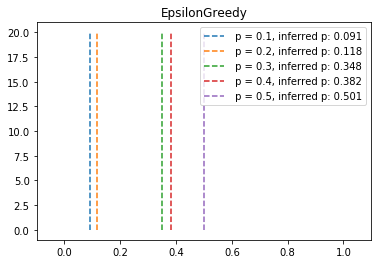

In [12]:
a.plot_result()

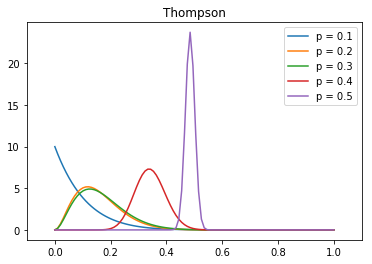

In [13]:
b.plot_result()

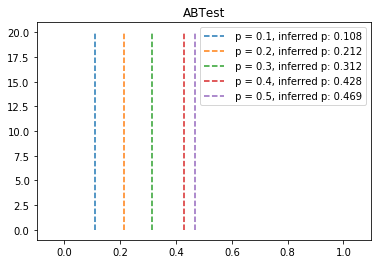

In [14]:
c.plot_result()

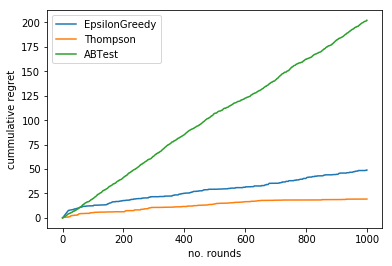

In [11]:
plt.plot(np.arange(1000), a.cumRegret, label='EpsilonGreedy')
plt.plot(np.arange(1000), b.cumRegret, label='Thompson')
plt.plot(np.arange(1000), c.cumRegret, label='ABTest')
plt.ylabel('cummulative regret')
plt.xlabel('no. rounds')
plt.legend(loc=0)